# Mushroom Random Forest  with K-Fold Cross Validation

## Decision Tree

The Random Forest technique takes a dataset and then makes a series of decisions based on it to predict a conclusion.
This decision tree consists of deciding at each split of the tree branches what version of remaining data helps predict conclusions the most accurately. 

In one version of this called the CART algorithm calculates the GINI Impurity at each node (split of the tree). The Gini Impurity of a node is the probability that a randomly chosen sample in a node would arrive at the wrong conclusion, using the distribution of samples in the node. The algorithm repeats this process to remove as much doubt as possible. 

Thanks to Scikit-Learn, or Sklearn (how do you pronounce that?), it's not that hard!

We used the [Mushroom](http://archive.ics.uci.edu/ml/datasets/Mushroom) dataset from the UCI Machine Learning Repo. 

Let's try to predict whether a random mushroom is poisonous or not!

In [1]:
#Upload Packages and data
import pandas as pd
from sklearn import ensemble, tree
from sklearn.model_selection import train_test_split
from error_metrics import *
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Read in the data
data = pd.read_csv('mushroom.csv')
print(data.shape)
data.head()

(8124, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


With 23 columns and 8,124 rows, our model has a lot of data on which to train.
However, we need clean and useful values, and only numbers.

## Data Cleaning

In [2]:
#Number of rows before
print("Before cleaning. Rows =",str(len(data)))

def clean_shrooms(data):
    #Drop the values in the previously stated columns
    data = data[data['cap-shape'] != 'c']
    data = data[data['cap-surface'] != 'g']
    data = data[data['stalk-color-above-ring'] != 'y']
    data = data[data['veil-color'] != 'y']

    #Drop veil-type
    data = data.drop('veil-type',axis=1)

    #Replace ? with u in stalk-root
    data = data.replace(to_replace ="?", value ="u") 
    
    return data
    
data = clean_shrooms(data)
print("After cleaning. Rows =",str(len(data)))

Before cleaning. Rows = 8124
After cleaning. Rows = 8111


We removed 13 rows of data containing unuseful data.

## Prepping data for Random Forest

Now we must convert characters into numbers for the algorithm to use. 

Additionally we want to prevent the possibility of over-fitting, 
so we will split our data into training and testing data.

In [3]:
def prep_dataframe_for_random_forest(data):

    #Removing the target variable
    features = list(data)
    features.remove('class')
    data_x = data[features]
    data_y = data['class']

    #Convert Class to 1 and 0 and OneHotEncode other columns to 1 and 0
    data_y.replace({'e':0,'p':1}, inplace=True)
    data_x = pd.get_dummies(data_x) 
    
    return data_x, data_y

data_x, data_y = prep_dataframe_for_random_forest(data)
# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.3, random_state = 4)

## Creating the random forest

1. Build a sequence of Random Forest models for different n_est and depth values (how many variables for each tree)
2. Aggregate the model results into a single dataframe for analysis and graphing. 

In [4]:
#Random Forest

n_ests = [5, 8, 10, 20, 50, 100] 
    #Number of estimators meaning the number of 'trees' being considores for the model
depths = [2, 4, 6, 8, 20] 
    #How deep are the trees meaning how many variables are considered in building a single tree

#Create a dataframe containing n_ests, depth, and accuracy so it can be plotted
ne = []
dep = []
acc = []
picklelist = []
picklenames = []
variableNames = list(x_train.columns)
counter = [0]*len(list(x_train.columns))
variableImportanceTracker = {'variable': list(x_train.columns)}
variableScoreTracker = []
for n in n_ests:
    for dp in depths:
        mod = ensemble.RandomForestClassifier(n_estimators = n, max_depth = dp)
        mod.fit(x_train, y_train)
        #save each model to a list, pick one later to save
        s = pickle.dumps(mod)
        picklelist.append(s)
        picklenames.append(f"shroom_model_n{n}_dp{dp}.p")
        
        y_hat = mod.predict(x_test)
        print('------ Evaluating model: n_estimators =' + str(n) + ', max_depth = ' + str(dp),'------')
        print_binary_classif_error_report(y_test, y_hat)
        ne.append(n)
        dep.append(dp)
        acc.append(accuracy_score(y_test, y_hat))
        
        print('------ Important features model: n_estimators =' + str(n) + ', max_depth = ' + str(dp),'------')
        importanceScoreRF = [] #create a list to hold the score
        importance = mod.feature_importances_ # get the measured importance
        #Get a list of the importance scores
        for i,v in enumerate(importance):
            importanceScoreRF.append(v)
        #Record the number of times a variable is considered significant
        for i in range(len(importanceScoreRF)):
            if importanceScoreRF[i] > 0:
                counter[i] += 1
        #Add the scores to a list which will be used to create a dataframe of variable scores
        importanceScoreRF.append(n)
        importanceScoreRF.append(dp)
        variableScoreTracker.append(importanceScoreRF)

------ Evaluating model: n_estimators =5, max_depth = 2 ------
Accuracy: 0.891125718981101
Precision: 0.9822175732217573
Recall: 0.7910699241786016
F1: 0.8763415772281847
ROC AUC: 0.8887186028270714
Confusion Matrix: 
[[1230   17]
 [ 248  939]]
------ Important features model: n_estimators =5, max_depth = 2 ------
------ Evaluating model: n_estimators =5, max_depth = 4 ------
Accuracy: 0.9909613804437141
Precision: 1.0
Recall: 0.9814658803706824
F1: 0.9906462585034014
ROC AUC: 0.9907329401853412
Confusion Matrix: 
[[1247    0]
 [  22 1165]]
------ Important features model: n_estimators =5, max_depth = 4 ------
------ Evaluating model: n_estimators =5, max_depth = 6 ------
Accuracy: 0.9967132292522597
Precision: 1.0
Recall: 0.9932603201347936
F1: 0.9966187658495351
ROC AUC: 0.9966301600673968
Confusion Matrix: 
[[1247    0]
 [   8 1179]]
------ Important features model: n_estimators =5, max_depth = 6 ------
------ Evaluating model: n_estimators =5, max_depth = 8 ------
Accuracy: 1.0
Pre

## Measuring Quality of the Model

The results tell us that there was equal accuracy across the different n_est and depths inputs. 

In [5]:
#Create a dataframe containing n_estimators, max_depth, and accuracies
accMeasure = {'n_ests':ne,'depths':dep,"accuracy":acc}
accMeasure = pd.DataFrame(accMeasure)
accMeasure.sort_values(by=['accuracy'], ascending=False).head()

,n_ests,depths,accuracy
29,100,20,1.0
8,8,8,1.0
24,50,20,1.0
23,50,8,1.0
19,20,20,1.0


## K-Fold Cross Validation
In order to minimize the bias involved in the training procedure when evaluating the performance of our model, we use K-Fold cross validation. We do this by instanciating an object of the CV class and running the split() method which splits the data set into k folds. Each fold serves as the testing set for a random forest that is trained on every point not in the fold and the performance of the model is averaged over the performance in each fold.

The value of k is generally chosen to be 5 or 10, however, there is no rule for this selection. A higher value of k decreases the difference between the training set and the sampled subsets and thus decreases bias associated with evaluating the model. However, the higher the value of k then the larger the overlap between the different testing sets, which causes the variance associated with the estimate to increase.

We chose a k value of 10 because it has a good trade off between bias, variance and overall computational efficiency.

In [6]:
from sklearn.metrics import accuracy_score
from sklearn import ensemble
from CV import * 
# Splitting df
y = data_y
x = data_x
# Setting up cross-validation
cv=CV(x,y)
x_shuff, y_shuff = cv.shuffle() # shuffling data sets
train_indices,test_indices = cv.split() # nsplits = 10 by default
n=50 # number of estimators
dp = 8 # max-depth
acc_list = []

for train_idx, test_idx in zip(train_indices,test_indices):
        x_train, y_train = x_shuff.loc[train_idx], y_shuff.loc[train_idx]
        x_test, y_test = x_shuff.loc[test_idx], y_shuff.loc[test_idx]
        mod = ensemble.RandomForestClassifier(n_estimators = n, max_depth = dp)
        mod.fit(x_train, y_train)
        y_hat = mod.predict(x_test)
        accuracy = accuracy_score(y_test,y_hat) 
        acc_list.append(accuracy)
accuracy_avg = sum(acc_list)/len(acc_list)
print("Accuracy average for all folds: {0:.6f}".format(accuracy_avg))


Accuracy average for all folds: 0.999753


## Measuring The Significance Of Predictors

Within the accumulated results, we can measure how many times each predictor variable was evaluated as significant.

In [7]:
#Create a dataframe that has the variable name and the number of times it is considered significant out of 30
variableImportanceTracker['counter'] = counter
variableImportanceTracker = pd.DataFrame(variableImportanceTracker)
variableImportanceTracker.sort_values(by=['counter'], ascending=False).head(15)

,variable,counter
55,stalk-surface-above-ring_k,29
25,odor_n,29
33,gill-size_b,28
34,gill-size_n,28
89,ring-type_p,28
93,spore-print-color_n,28
22,odor_f,28
19,bruises_t,28
32,gill-spacing_w,27
31,gill-spacing_c,27


## Measuring Significance of a Predictor 

Plots can help us understand the results using the number of estimates and depth.
First we must compile into a dataframe, then visualize. 

In [8]:
#Create a dataframe containing the significance scores of each of the variables as well as the number of estimates and the depth where they were considered significant
scoreColumns = list(x_train.columns)
scoreColumns.append('n_estimates')
scoreColumns.append('depth')

variableScoreTracker = pd.DataFrame(variableScoreTracker, columns = scoreColumns)
variableScoreTracker.head()

,cap-shape_b,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_s,cap-surface_y,cap-color_b,cap-color_c,...,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,n_estimates,depth
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015274,0.0,5,2
1,0.000000,0.000000,0.000006,0.000000,0.000000,0.000000,0.000000,0.000070,0.000000,0.000000,...,0.008746,0.000000,0.000000,0.000000,0.002491,0.036809,0.000000,0.0,5,4
2,0.000000,0.000000,0.000000,0.002484,0.000000,0.014063,0.000000,0.000007,0.001435,0.000000,...,0.000000,0.002312,0.000000,0.000000,0.000000,0.010150,0.002103,0.0,5,6
3,0.000000,0.000244,0.000000,0.000000,0.000000,0.000000,0.008072,0.000000,0.000000,0.000000,...,0.000000,0.000694,0.000015,0.000000,0.000000,0.000000,0.022396,0.0,5,8
4,0.001201,0.001568,0.000000,0.000593,0.002518,0.007049,0.000022,0.000010,0.001141,0.000006,...,0.004159,0.005548,0.000071,0.000377,0.000466,0.000000,0.007505,0.0,5,20


## Using the Dataframes now we can graph!

Text(0.5, 1.0, '# of variables vs Accuracy')

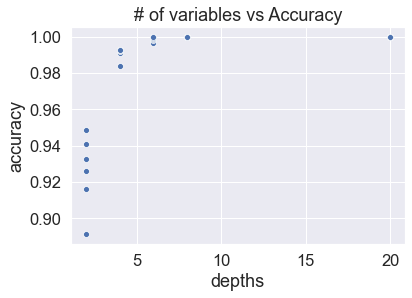

In [9]:
sns.set(font_scale=1.5) #make sure text is big enough to read

#Plotting the depth/# of variables vs the accuracy
sns.scatterplot(x="depths", y="accuracy", data=accMeasure).set_title("# of variables vs Accuracy")

#Summary: More variables means more accuracy but there is a danger of overfitting

Text(0.5, 1.0, 'Num Estimates vs Accuracy')

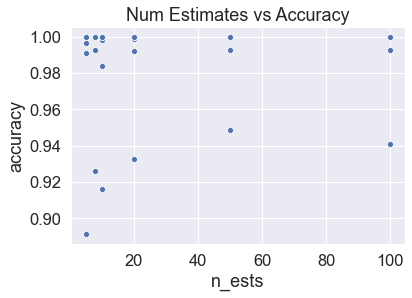

In [10]:
#Plotting the number of estimates/trees vs the accuracy
sns.scatterplot(x="n_ests", y="accuracy", data=accMeasure).set_title("Num Estimates vs Accuracy")

#Summary: More trees doesn't necessarily mean more accuracy

# Once Model is Chosen, Save to a Pickle 

In [11]:
finalchoice = "shroom_model_n50_dp8.p"
ind = picklenames.index(finalchoice)

pickle.dump( picklelist[ind], open(finalchoice, "wb" ) )

# Test Using the Pickle File

In [12]:
# read in the original dataset and example row to process
data = pd.read_csv('mushroom.csv')
use_df = pd.read_csv("use_model.csv")

# join datasets to ensure all categories are accounted for
use_df = pd.concat([data,use_df])

# Process the raw data as in the model process
use_data = clean_shrooms(use_df)
use_data_x, use_data_y = prep_dataframe_for_random_forest(use_data)

# Grab the last rows, representing new input
use_data_x = use_data_x.iloc[[-1]]
use_data_y = use_data_y.iloc[[-1]]

with open('shroom_model_n50_dp8.p', 'rb') as f:
   mush_model = pickle.load(f)

#Load the model
mush_model = pickle.loads(mush_model)

In [13]:
#Use the model on our test data
xpred = mush_model.predict(use_data_x)
print(f"prediction from the saved model:  {xpred[0]}\n")
print(f"   actual value from tested row: {use_data_y.to_string(index=False)}")


prediction from the saved model:  1

   actual value from tested row:  1


Text(0.5, 1.0, 'Histogram of Incidences of Variable Significance')

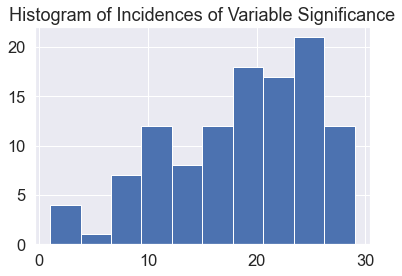

In [14]:
#Out of 30 random forests how many times was a particular variable considered significant?
variableImportanceTracker['counter'].hist().set_title("Histogram of Incidences of Variable Significance")

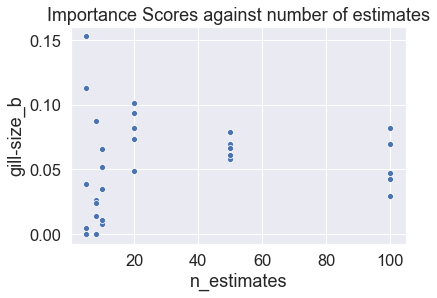

In [15]:
#Plotting the number of estimates/trees vs the score of gill-size_b
pltme = sns.scatterplot(x="n_estimates", y="gill-size_b", data=variableScoreTracker).set_title("Importance Scores against number of estimates")

Text(0.5, 1.0, 'Depth vs Gill-size_b score')

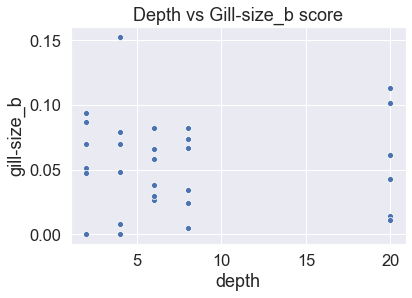

In [16]:
#Plotting the depth vs the score of gill-size_b
sns.scatterplot(x="depth", y="gill-size_b", data=variableScoreTracker).set_title("Depth vs Gill-size_b score")

Text(0.5, 1.0, '# Trees vs Score for Odor_n')

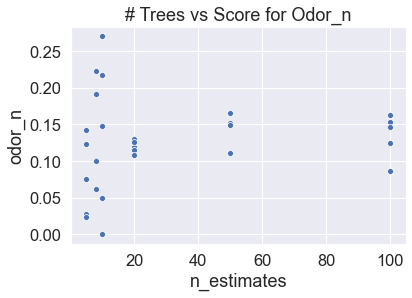

In [17]:
#Plotting the number of estimates/trees vs the score of odor_n
sns.scatterplot(x="n_estimates", y="odor_n", data=variableScoreTracker).set_title("# Trees vs Score for Odor_n")

Text(0.5, 1.0, 'Depth vs Score for Odor_n')

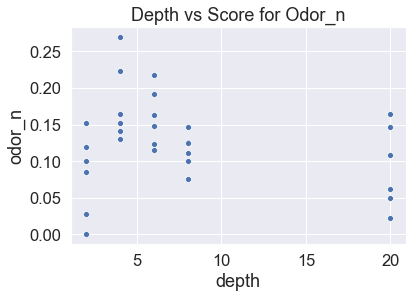

In [18]:
#Plotting the depth vs the score of odor_n
sns.scatterplot(x="depth", y="odor_n", data=variableScoreTracker).set_title("Depth vs Score for Odor_n")

## Significance Score Sums (1=all significant)

In [19]:
#Note that when a group of variables are considered significant the sum of all of the variables' significance scores is 1
variableScoreTracker.iloc[:, :-2].sum(axis = 1)

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
dtype: float64

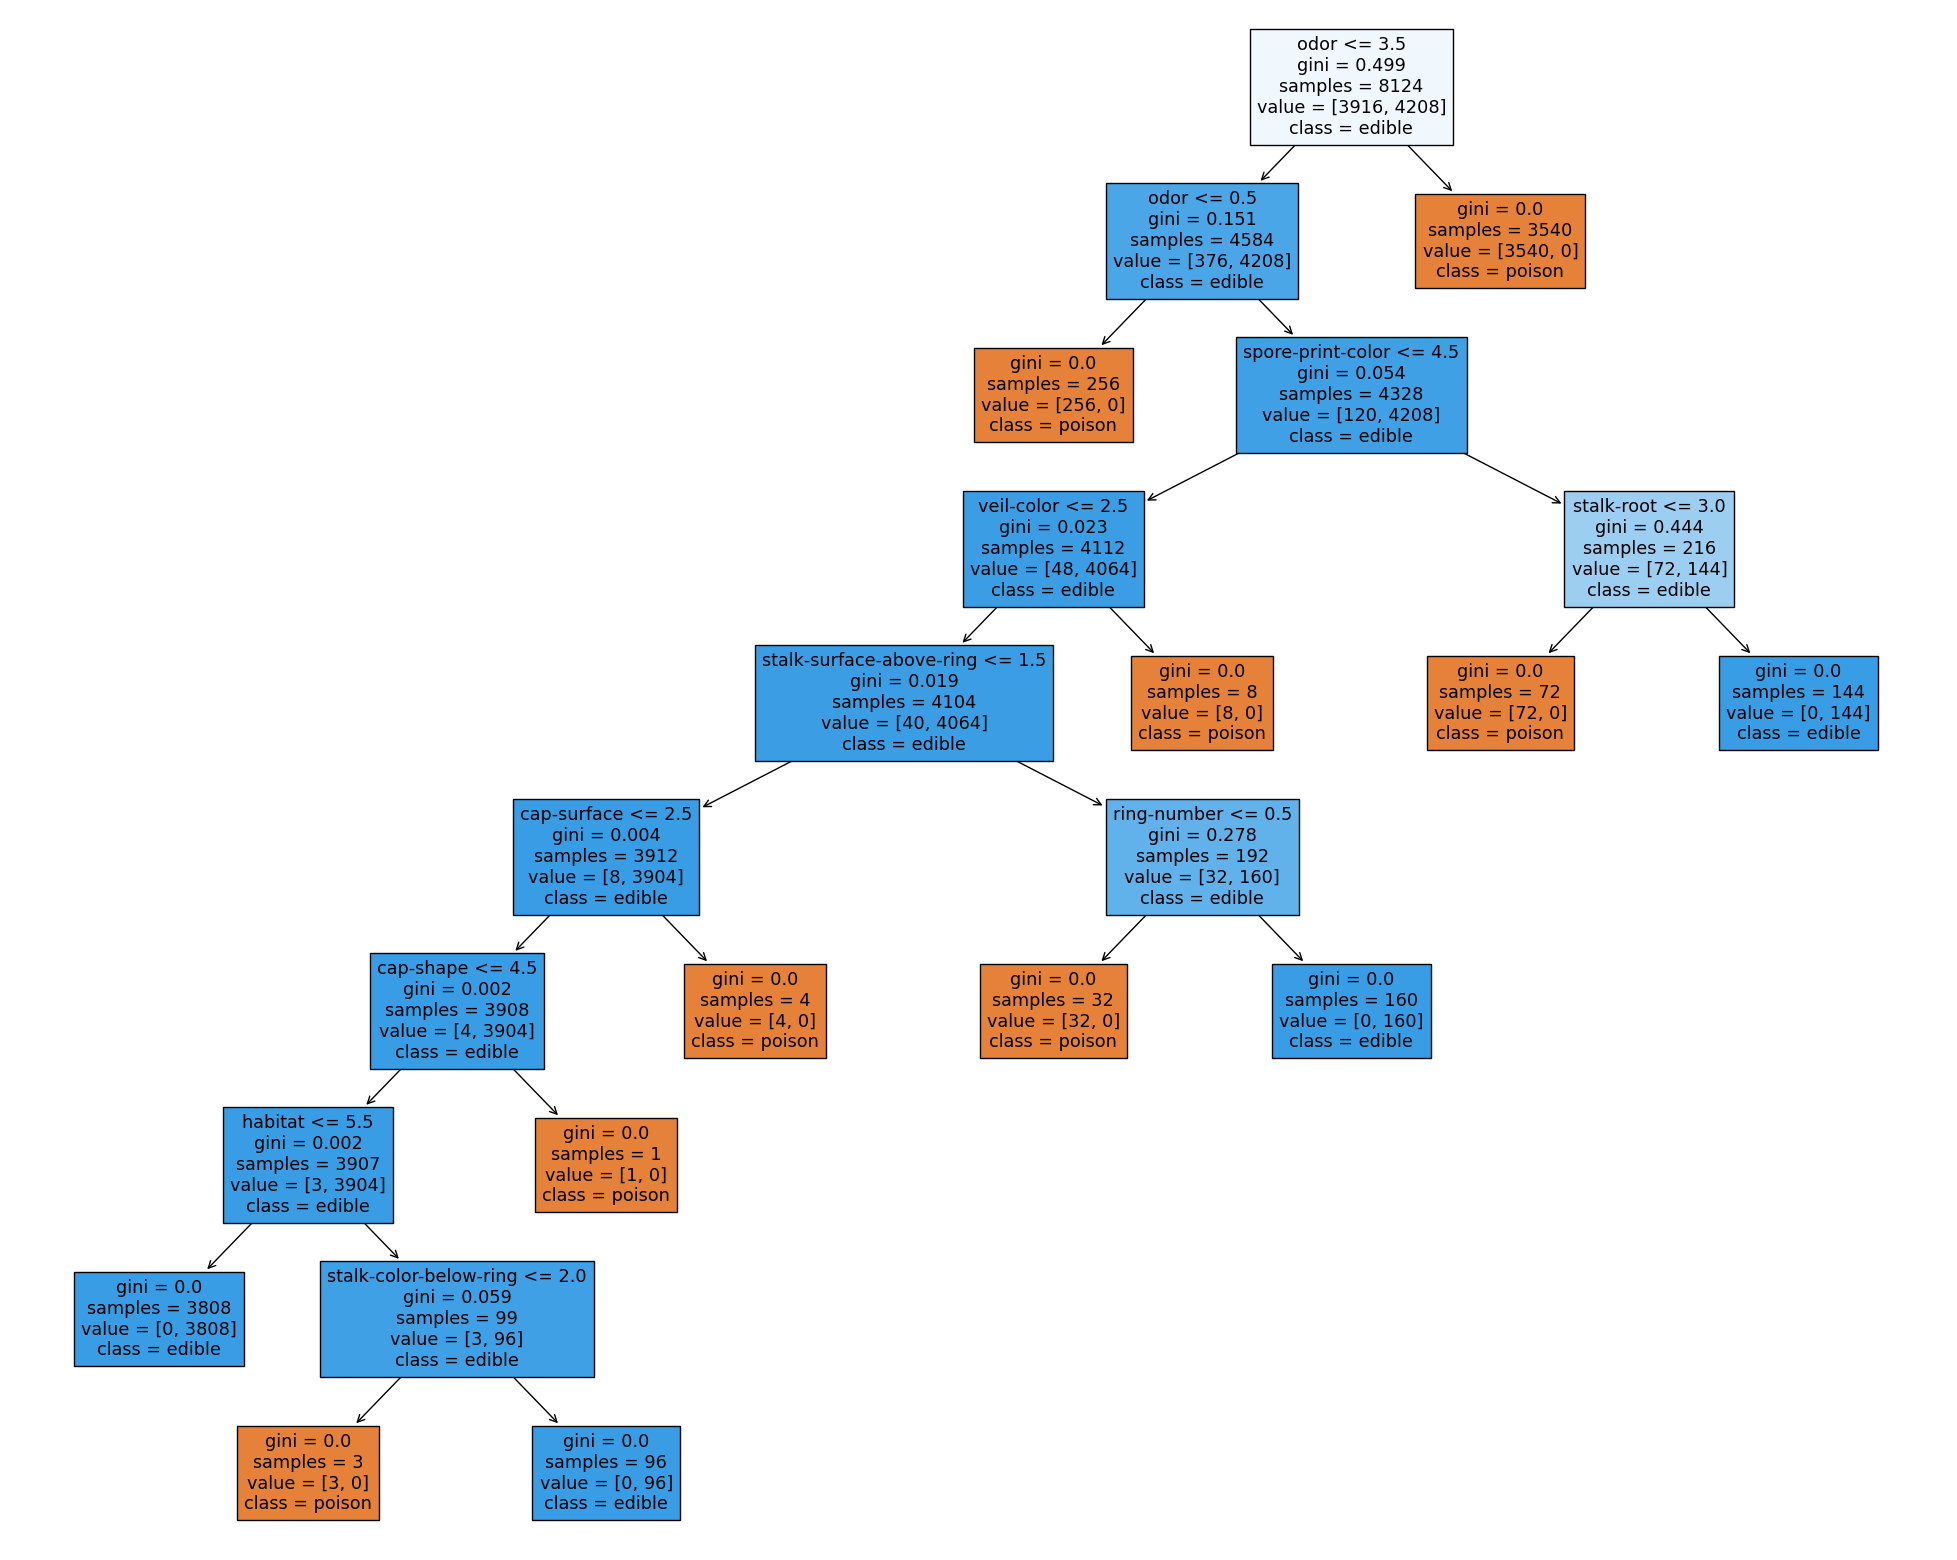

In [20]:
sns.reset_orig()

#make copy of the dataframe to change
shroomies = data.copy()

#get names of columns 2+
nonclass = list(data.columns)[1:]

#convert values to numbers for analysis
for key, value in shroomies.iteritems(): 
    codes, uniques = pd.factorize(value) 
    shroomies[key] = codes

#separate out data and target
shroom_data = shroomies[nonclass]
shroom_target = shroomies['class']

# Fit the classifier with default hyper-parameters
clf = tree.DecisionTreeClassifier(random_state=1234)
model = clf.fit(shroom_data, shroom_target)
#with plt.style.context('seaborn-colorblind'):
fig = plt.figure(figsize=(25,20))

_ = tree.plot_tree(clf, 
                   feature_names=nonclass,  
                   class_names=['poison', 'edible'],
                   filled=True)
